In [3]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

import time

from dfply import *

from scipy.cluster.hierarchy import dendrogram, linkage

# First Ideas and Explorations
Idea: Calculate the difference to first place. Maybe that is easier to analyze.

In [4]:
lap_times = pd.read_csv("f1db_csv/lap_times2018.csv")
df_drivers = pd.read_csv("f1db_csv/driver.csv")

In [5]:
def driver_name(driverId):
    driver = df_drivers.loc[ df_drivers["driverId"]==driverId, "surname"].values[0]
    
    return driver

We'll start with just two drivers in Australia: Hamilton and Vettel.

In [6]:
# Vettel's database
vet = (lap_times >>
       mask(X.raceId == 989, X.driverId==20) >>
       arrange(X.lap))

# Hamilton's database
ham = (lap_times >>
       mask(X.raceId == 989, X.driverId==1) >>
       arrange(X.lap))

# Number of laps in the race
num_laps = max((lap_times >>mask(X.raceId == 989)).lap)

In [7]:
total_vet = 0
total_ham = 0

ham_diff = []
vet_diff = []

for i in range(num_laps):
    # Place after the i-th lap
    vet_pos = vet.iloc[i]["position"]
    ham_pos = ham.iloc[i]["position"]
    
    vet_lap = vet.iloc[i]["milliseconds"]
    ham_lap = ham.iloc[i]["milliseconds"]
    
    total_vet += vet_lap
    total_ham += ham_lap
    
    # Look who is ahead
    if(ham_pos < vet_pos):
        # If Ham is ahead, calculate Vet's difference
        ham_diff.append(0)
        vet_diff.append(total_vet - total_ham)
    else:
        # Do the opposite otherwise
        ham_diff.append(total_ham - total_vet)
        vet_diff.append(0)

In [8]:
vet_diff

[1961,
 2258,
 2626,
 2763,
 3142,
 3526,
 3683,
 4072,
 4377,
 4158,
 4322,
 4398,
 4972,
 5675,
 6112,
 6679,
 7522,
 8204,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

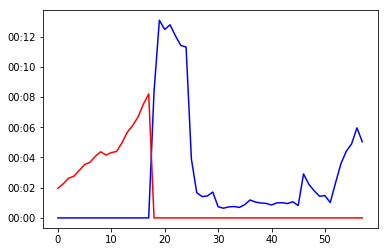

In [9]:
tt = range(num_laps)

fig, ax = plt.subplots();

plt.plot(tt, ham_diff, color="blue")
plt.plot(tt, vet_diff, color="red")

formatter = FuncFormatter(lambda ms, x: time.strftime('%M:%S', time.gmtime(ms // 1000)))
ax.yaxis.set_major_formatter(formatter)

plt.show()

# Time differences
Here we calculate the gap to first place. We also have a function to plot it

In [132]:
def delta_to_first(race, df=lap_times):
    race_df  = (df >>
                mask(X.raceId == race) >>
                arrange(X.lap))

    # Number of laps
    num_laps = max(race_df.lap)

    # Drivers that finished the race
    drivers = (race_df >>
               mask(X.lap == num_laps) >>
               select(X.driverId))
    drivers = np.unique(drivers.driverId)

    # Differences
    diff = {}
    total_times = {}
    driver_times = {}

    for driver in drivers:
        diff[driver] = []
        total_times[driver] = 0
        driver_times[driver] = 0

    for i in range(1,num_laps+1):
        # lt stands for lap times
        lt = (race_df >> mask(X.lap==i))

        # Find first place
        first = lt.loc[ lt["position"].idxmin() ]["driverId"]

        # Get lap times
        for driver in drivers:
            driver_times[driver] = lt.loc[ lt["driverId"]==driver, "milliseconds"].values[0]
            total_times[driver] += driver_times[driver]

        # Calculate differences
        for driver in drivers:
            diff[driver].append(np.abs(total_times[first] - total_times[driver]))
        
    return(diff, drivers)

def plot_delta_to_first(race, df=lap_times):
    # Plot all differences in the same graph
    diff2, drivers = delta_to_first(989, df=df)

    formatter = FuncFormatter(lambda ms, x: time.strftime('%M:%S', time.gmtime(ms // 1000)))
    fig, ax = plt.subplots();

    for driver in drivers:
        plt.plot(diff2[driver], label=driver_name(driver))

        ax.legend(loc='center right', bbox_to_anchor=(1.35, 0.5))

        ax.yaxis.set_major_formatter(formatter)

In [11]:
lt.loc[ lt["position"].idxmin() ]

raceId               998
driverId              20
lap                   52
position               1
time            1:31.594
milliseconds       91594
Name: 9773, dtype: object

Plotting the gaps in a single race for every driver individually:

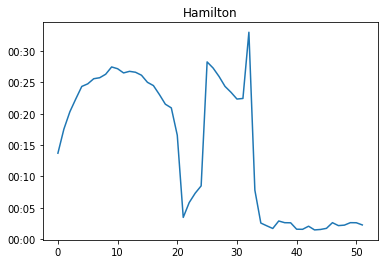

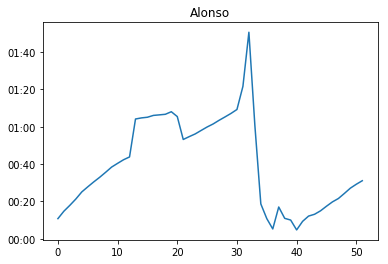

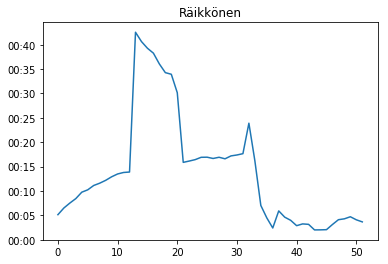

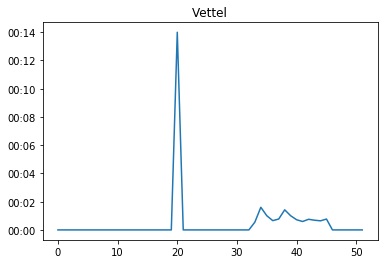

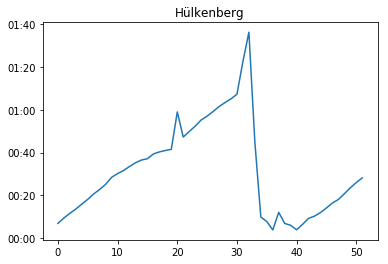

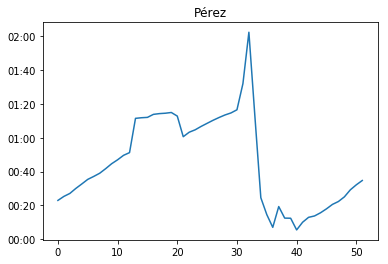

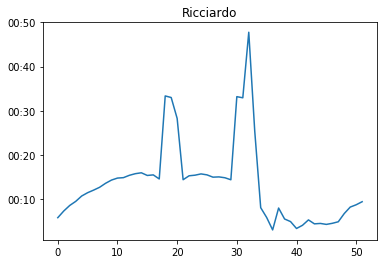

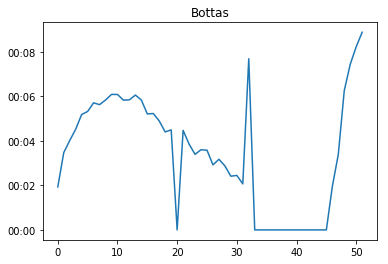

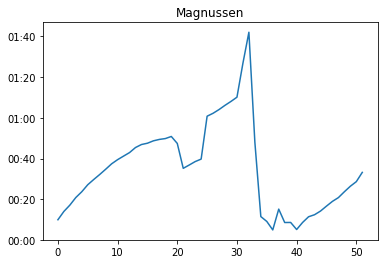

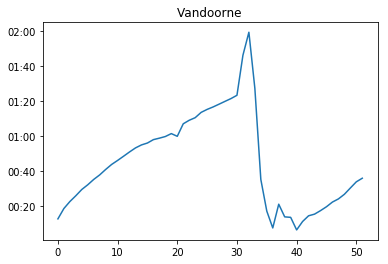

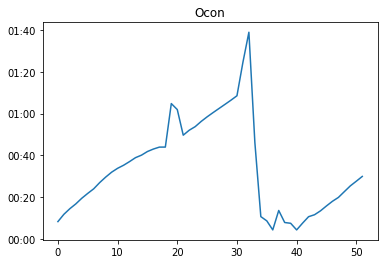

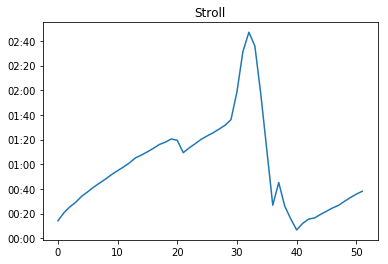

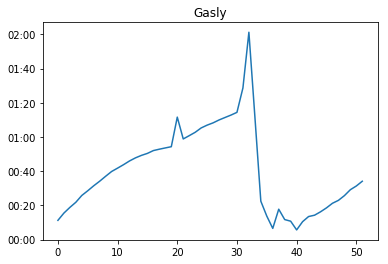

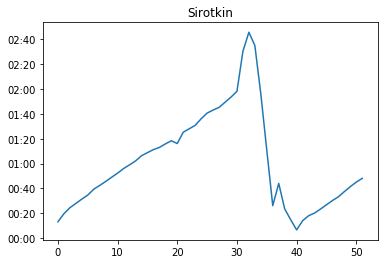

In [12]:
# Plot all differences
tt = range(num_laps)
formatter = FuncFormatter(lambda ms, x: time.strftime('%M:%S', time.gmtime(ms // 1000)))

for driver in drivers:
    fig, ax = plt.subplots();

    plt.plot(tt, diff[driver])
    plt.title(driver_name(driver))
    
    ax.yaxis.set_major_formatter(formatter)

And now all together

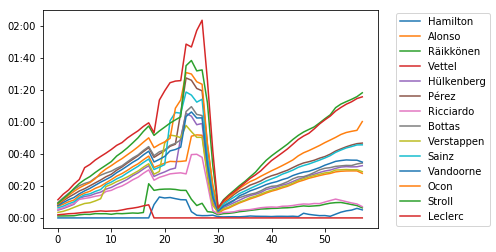

In [133]:
plot_delta_to_first(998)

# Try to define a distance
Define a metric between two drivers as: $ \frac{1}{n} \sum_{i=1}^n (t_i - s_i)^2 $ where $t_i$ is the lap time of the first driver in lap $i$ (same for $s_i$) and $n$ is the number of laps in the race.

In other words, our metric is the mean squared distance between lap times in a single race.

In [92]:
def lap_differences(driver1, driver2, raceId, df=lap_times):
    # Gives a list with the difference lap times of driver1 minus those of driver2
    race_times  = (df >>
                   mask(X.raceId == raceId, (X.driverId==driver1) | (X.driverId==driver2)) >>
                   arrange(X.lap))

    # Get times for each driver
    times1 = (race_times >>
              mask(X.driverId==driver1) >>
              select(X.milliseconds, X.lap))
    
    times2 = (race_times >>
              mask(X.driverId==driver2) >>
              select(X.milliseconds, X.lap))
    
    # Get the laps that they both did
    laps1 = max(times1.lap)
    laps2 = max(times2.lap)
    minlaps = min(laps1, laps2)

    # The difference
    diff = np.array((times1.milliseconds).add(-times2.milliseconds.values))
    
    # Turn it into seconds (not milliseconds) before returning
    return(diff/1000)

def delta_per_lap(driver1, driver2, raceId, df=lap_times):
    # Get the difference in each lap time
    diff = lap_differences(driver1, driver2, raceId, df=df)
    
    # To get the difference on track, do the cumulative sum
    delta = [0]
    for i in range(len(diff)):
        delta.append( delta[i]+diff[i] )
    
    return(np.array(delta))

def sum_of_squares(vector):
    return(np.sum(np.square(np.array(vector))))

def mse(vector):
    return(np.mean(np.square(np.array(vector))))

The above functions match the calculations we'd done before, except for a slight offset. There is a 0 in the first coordinate, but it doesn't change the analysis at all.

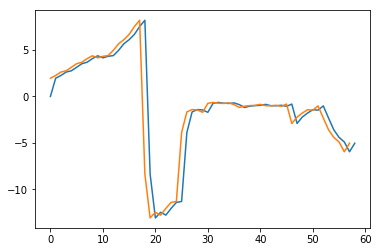

In [134]:
delta = delta_per_lap(1,20,989)

plt.plot(-np.array(delta))
plt.plot((-np.array(ham_diff) + np.array(vet_diff))/1000)

Now, let's try to do some clustering on a single race with the drivers that finished

In [90]:
def race_distances(raceId, df = lap_times):
    # Get the drivers that finished in this race
    race_times  = (df >>
                   mask(X.raceId == raceId) >>
                   arrange(X.lap))

    # Number of laps
    num_laps = max(race_times.lap)

    # Drivers that finished the race (sort them by position)
    drivers = (race_times >>
               mask(X.lap == num_laps) >>
               arrange(X.position) >>
               select(X.driverId))

    drivers = drivers.driverId.values
    _, idx = np.unique(drivers, return_index=True)
    drivers = drivers[np.sort(idx)]

    # Get all distances
    distances = []
    for i in range(len(drivers)):
        row = []
        for j in range(len(drivers)):
            driveri = drivers[i]
            driverj = drivers[j]

            row.append( mse(delta_per_lap(driveri, driverj, raceId, df=df)) )

        distances.append(row)

    distances = np.array(distances)
    return(distances, drivers)

/home/MRGomez/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  


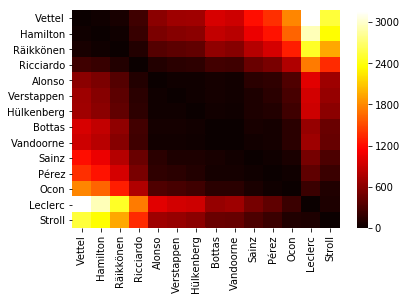

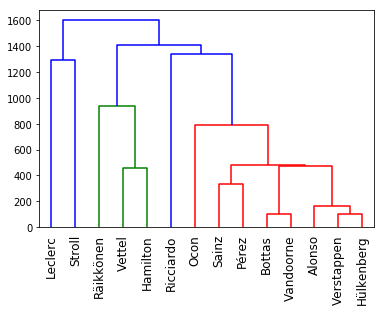

In [17]:
distances, drivers = race_distances(989)
names = [driver_name(id) for id in drivers]

sns.heatmap(distances, cmap="hot",
            xticklabels=names, yticklabels=names)

plt.figure()
linked = linkage(distances);
diag = dendrogram(linked, labels=names, leaf_rotation=90)

# Filling missing data
## Big gaps
Ok, this is working very well! The only problem is that we can only evaluate the drivers that finished the race and have a gap smaller than 1 lap. We need to find a way to incorporate all drivers into the ranking. For those that were n laps behind, we can simply copy their last lap time.

NOTE: This is not standard. We do this just to fill available space.

In [103]:
def fill_laps_behind(data, race, driver):
    # Get the total laps in the race
    num_laps = max((data >> mask(X.raceId == race)).lap)
    
    # Get the laps our driver did
    driver_laps = max((data >> mask(X.raceId == race, X.driverId==driver)).lap)
    
    # Now we get the last available lap
    last_lap = (data >> mask(X.raceId==race, X.driverId==driver, X.lap==driver_laps))
    
    # And we copy that lap until we fill all remaining laps
    new_data = data.copy()
    for i in range(driver_laps+1, num_laps+1):
        filler_lap = last_lap.copy()
        
        # Update the lap number
        filler_lap.lap = i
        
        # Add to the race data frame
        new_data = pd.concat([new_data, filler_lap])

    # Sort the array into a nice shape so as to not mess up with future analises.
    new_data = (new_data >>
                arrange(X.raceId, X.driverId, X.lap))

    return(new_data)

Ok, we filled missing laps. Let's calculate distances again. We should expect the drivers with filled laps to be further away from the leaders than the previous last place drivers.

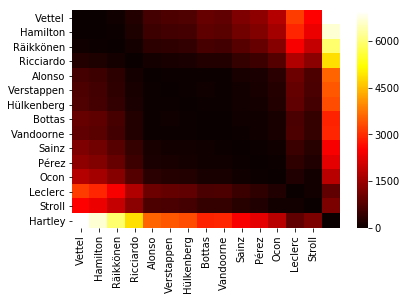

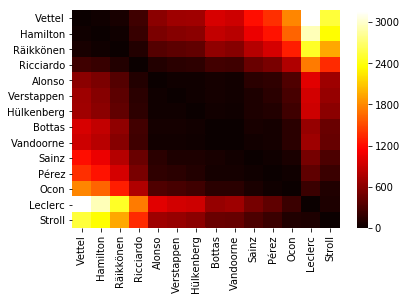

In [157]:
# Fill laps
australia_filled = fill_laps_behind(australia, 989, 843)

# Calculate distances
distances_f, drivers_f = race_distances(989, df=australia_filled)
names_f = [driver_name(id) for id in drivers_f]

# Plot them
sns.heatmap(distances_f, cmap="hot",
            xticklabels=names, yticklabels=names_f)

# Compare this with the old ranking
distances, drivers = race_distances(989)
names = [driver_name(id) for id in drivers]

plt.figure()
sns.heatmap(distances, cmap="hot",
            xticklabels=names, yticklabels=names)

The driver that finished with a one lap gap in Australia was Brendon Hartley. Indeed, our heatmap shows that he is considerably behind the rest of the pack.

/home/MRGomez/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  This is separate from the ipykernel package so we can avoid doing imports until
/home/MRGomez/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  import sys


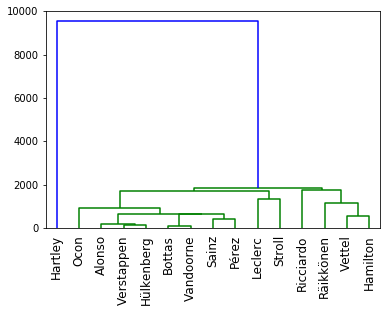

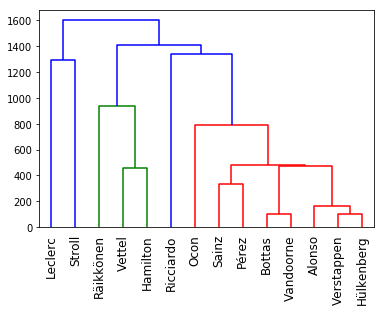

In [105]:
# And compare the dendrograms
plt.figure()
linked_f = linkage(distances_f);
diag = dendrogram(linked_f, labels=names_f, leaf_rotation=90)

plt.figure()
linked = linkage(distances);
diag = dendrogram(linked, labels=names, leaf_rotation=90)

The dendrograms tell a similar story. Note that Hartley was way behind during the whole race, so his distance is big enough as to deserve a single leaf in the dendrogram.

## DNF's
DNF's are more problematic. We want to penalize DNF's but not too heavily as to skew the overall model. Some ideas come to mind to fill the missing laps:
- Assign the slowest lap time available in each lap.
- Assign the lap time of the driver that finished in the place the current driver retired from. (Eg. driver 10 crashed, so we fill in the lap times of the driver that finished the race in 10th place).
- Assign the average of all other lap times.

We will define the three methods above and evaluate the performance of the final model.

In [135]:
def fill_laps(data, race, driver, method):
    # Get the total laps in the race
    num_laps = max((data >> mask(X.raceId == race)).lap)
    
    # Get the laps our driver did
    driver_laps = max((data >> mask(X.raceId == race, X.driverId==driver)).lap)
    
    # And we copy that lap until we fill all remaining laps
    new_data = data.copy()
    for lap_index in range(driver_laps+1, num_laps+1):
        filler_lap = method(data, race, driver, lap_index)
        
        # Update the lap number
        filler_lap.lap = lap_index
        
        # Add to the race data frame
        new_data = pd.concat([new_data, filler_lap])

    # Sort the array into a nice shape so as to not mess up with future analises.
    new_data = (new_data >>
                arrange(X.raceId, X.driverId, X.lap))

    return(new_data)

In [155]:
def slowest_time(data, race, driver, lap_index):
    # Picks the slowest time in the lap (ie. the biggest time)
    lap_df = (data >>
              mask(X.raceId==race, X.lap==lap_index))
    
    return(max(lap_df.milliseconds.values))

def time_same_position(data, race, driver, lap_index):
    # Finds the position of our driver in his last lap
    driver_df = (data >> mask(X.raceId==race, X.driverId==driver))
    last_lap = max(driver_df.lap.values)
    last_position = (driver_df >> mask(X.lap==last_lap)).position.values[0]
    
    # Now we pick the lap time of the driver in that position
    position_df = (data >> mask(X.raceId==race, X.position==last_position, X.lap==lap_index))
    new_time = position_df.milliseconds.values[0]
    
    return(new_time)

Testing that everything works as expected:

In [156]:
# This should be Brendon Hartley's 2:05.584 first lap in Australia 2018 (125584 milliseconds).
print(slowest_time(lap_times, 989, 843, 1))

125584


# Aggregating metrics
The next step is to define a metric for the whole season. The idea is to add the metrics from each race. We will weight each race by its qualyfing time. This should balance the track length and, perhaps, also the difficulty.